In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
sns.set()

# PART I - Regression Task

In [2]:
kick1 = np.genfromtxt(os.path.join("data", "kick1.dat"), delimiter=' ')
kick2 = np.genfromtxt(os.path.join("data", "kick2.dat"), delimiter=' ')

In [3]:
def plot_data(data, prediction=None):
    x, y, z = data[:, 0], data[:, 1], data[:, 2]

    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection="3d")
    ax.set_xlabel("x axis")
    ax.set_ylabel("y axis")
    ax.set_zlabel("z axis")
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 2.1)
    ax.set_zlim(0, 0.3)

    x_field = np.linspace(-3, 3, 2)
    y_field = np.linspace(0, 2.1, 2)
    x_field, y_field = np.meshgrid(x_field, y_field)
    z_field = np.zeros(x_field.shape)
    ax.plot_surface(x_field, y_field, z_field, shade=False, color='g', alpha=.4)

    ax.plot([-2.5, -2.5], [0, 1.25], zdir='z', c='g')
    ax.plot([-2.5, 2.5], [1.25, 1.25], zdir='z', c='g')
    ax.plot([2.5, 2.5], [0, 1.25], zdir='z', c='g')

    ax.scatter3D(x, y, z, c='b')
    if prediction is not None:
        x, y, z = prediction[:, 0], prediction[:, 1], prediction[:, 2]
        ax.scatter3D(x, y, z, c='r')
    #ax.view_init(30, 32)

    plt.show()

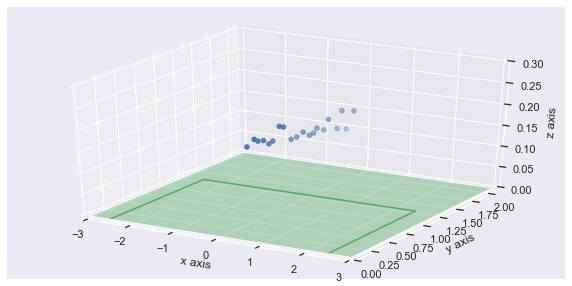

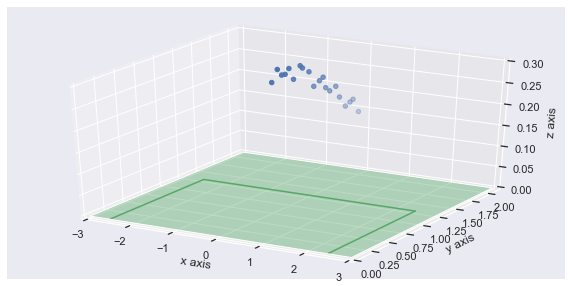

In [4]:
plot_data(kick1)
plot_data(kick2)

# PART II - Classification Task

Loading the dataset using sklearn function `load_digits`, and splitting data into training/test set, with 90% and 10% of the total data respectively. 

After the first split is done, 20% of the training set is used to generate a third set, the validation set, which will assist in the evaluation of the algorithm after training. 

In the end we have:
- 10% of the dataset in the test set (10% of 100%)
- 18% of the dataset in the validation set (20% of 90%)
- 72% of the dataset in the training set (80% of 90%)

In [5]:
X, y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    random_state=42)

## Data preprocessing

Applying a normalization to the input data, so that the range of features is in the interval of [0, 1]. Normalization is usefull to help the algorithm to converge to a solution faster, and also improves the numerical stability of the models.

In [6]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

## Plotting data using t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a unsupervised technique developed in 2008, which is mainly used for data exploration and visualizing high-dimensional data. Here it is used to recude the dimensionaly of the input data to 2, so we can have a intuition of how the data is arranged in the high-dimensional space.

As we can see in the plots, in general, it is possible to distinguish the digits well using the given features, but there are some digits, like 9 and 1, that are not well separated from the others, and therefore, we can expect lower precision in their classification. This behaviour can be observed in both training and validation set.

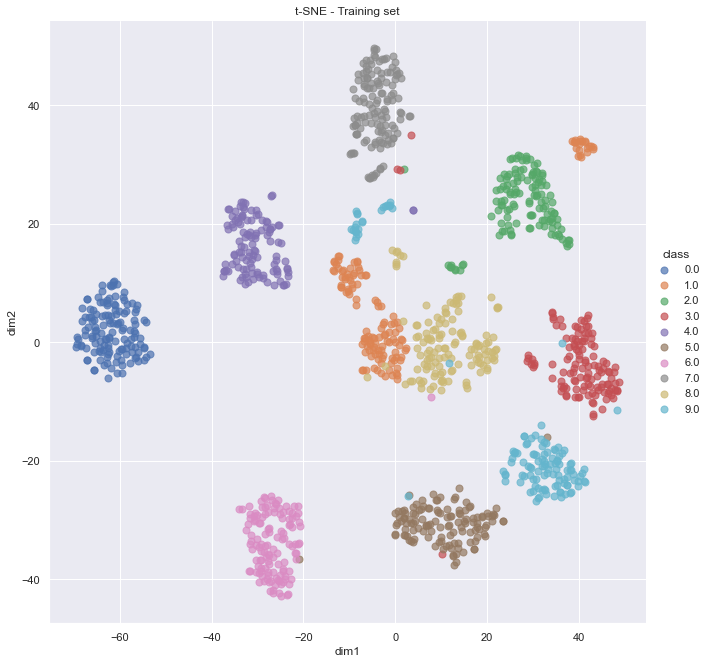

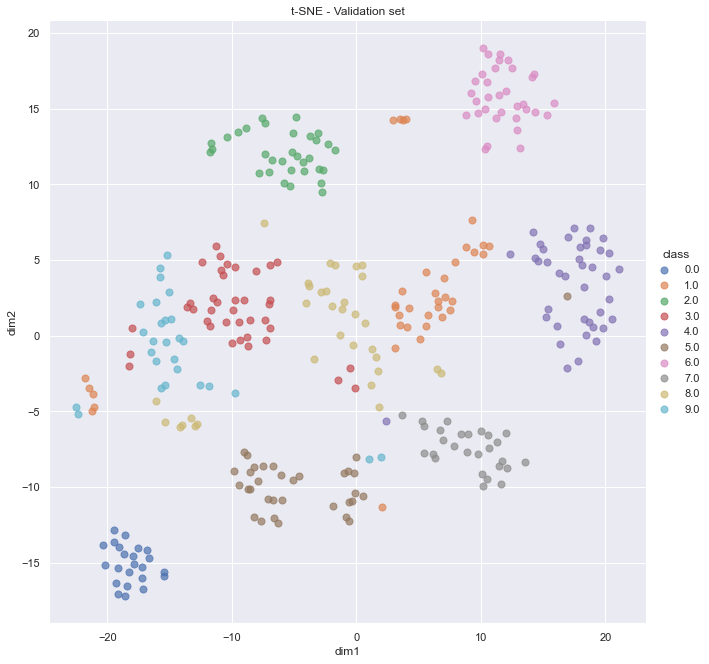

In [7]:
def plot_data_using_tsne(X, y, split="Training set"):
    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)
    X_embedded_df = pd.DataFrame(np.concatenate((X_embedded, y.reshape(-1, 1)), axis=1),
                                 columns=["dim1", "dim2", "class"])

    sns.lmplot(x="dim1",
               y="dim2",
               data=X_embedded_df,
               hue="class",
               height=9,
               fit_reg=False,
               legend=True,
               scatter_kws={'s': 50, 'alpha': 0.7})
    plt.title("t-SNE - {}".format(split))
    plt.show()
    
plot_data_using_tsne(X_train, y_train, split="Training set")
plot_data_using_tsne(X_valid, y_valid, split="Validation set")